#### Phase 1 - Data Ingestion and Initialization

In [1]:
#import libraies 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from rapidfuzz import fuzz, process
from sentence_transformers import SentenceTransformer, util


d:\Projects\PRODUCT_MATCHER_APP\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
external_df = pd.read_csv('D:\Projects\PRODUCT_MATCHER_APP\data\Data_External.csv')
internal_df = pd.read_csv('D:\Projects\PRODUCT_MATCHER_APP\data\Data_Internal.csv')

<>:1: SyntaxWarning: invalid escape sequence '\P'
<>:2: SyntaxWarning: invalid escape sequence '\P'
<>:1: SyntaxWarning: invalid escape sequence '\P'
<>:2: SyntaxWarning: invalid escape sequence '\P'
C:\Users\msura\AppData\Local\Temp\ipykernel_15348\4169927381.py:1: SyntaxWarning: invalid escape sequence '\P'
  external_df = pd.read_csv('D:\Projects\PRODUCT_MATCHER_APP\data\Data_External.csv')
C:\Users\msura\AppData\Local\Temp\ipykernel_15348\4169927381.py:2: SyntaxWarning: invalid escape sequence '\P'
  internal_df = pd.read_csv('D:\Projects\PRODUCT_MATCHER_APP\data\Data_Internal.csv')


#### PHASE 2 - Data Exploration

In [3]:
external_df.head()

,PRODUCT_NAME,UNIT_OF_MEASURE
0,5 HOUR XTRA GRAPE 1.93 OZ,1
1,B - PB & HONEY SAMMICH,1
2,B - RUDY FARMS - SAUSAGE AND BISCUIT TWIN,1
3,BANANAS - FRESH,1
4,BOBOS PB&J GRAPE 2.1 OZ,1


In [4]:
internal_df.head()

,NAME,OCS_NAME,LONG_NAME
0,3 Mskt DkChocMnt 1.24oz,3 Mskt DkChocMnt 1.24oz,3 Musketeers Dark Chocolate Mint (1.24oz)
1,NaN,Costco Choc Mini 4.69lb,Costco Chocolate Mini (4.69lb)
2,Dove Dk Choc Bars 1.3oz,Dove Dk Choc Bars 1.3oz,Dove Dark Chocolate Bars (1.3oz)
3,Fishers ChocPnut 3.5oz,Fishers ChocPnut 3.5oz,Fisher's Chocolate Peanuts (3.5oz)
4,HariboGummiGoldBear2oz,HariboGummiGoldBear2oz,Haribo Gummi Gold-Bears (2oz)


In [5]:
external_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   PRODUCT_NAME     43 non-null     object
 1   UNIT_OF_MEASURE  43 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 820.0+ bytes


In [6]:
internal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16192 entries, 0 to 16191
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   NAME       7454 non-null   object
 1   OCS_NAME   9292 non-null   object
 2   LONG_NAME  16192 non-null  object
dtypes: object(3)
memory usage: 379.6+ KB


In [7]:
print("External Null Values Record:\n",external_df.isnull().sum())
print()
print("Internal Null Values Record:\n",internal_df.isnull().sum())


External Null Values Record:
 PRODUCT_NAME       0
UNIT_OF_MEASURE    0
dtype: int64

Internal Null Values Record:
 NAME         8738
OCS_NAME     6900
LONG_NAME       0
dtype: int64


In [8]:
print("External Duplicate Record:",external_df.duplicated().sum())
print("Internal Duplicate Record:",internal_df.duplicated().sum())

External Duplicate Record: 0
Internal Duplicate Record: 2


In [9]:
# Shape and Info
print(f"External Data Shape: {external_df.shape}")
print(f"Internal Data Shape: {internal_df.shape}")

External Data Shape: (43, 2)
Internal Data Shape: (16192, 3)


In [10]:
print("\nMissing Values in Internal:")
missing_internal = internal_df.isnull().sum()
print(missing_internal)


Missing Values in Internal:
NAME         8738
OCS_NAME     6900
LONG_NAME       0
dtype: int64


In [11]:
#Unique Product Count
print("\nUnique External Products:", external_df.iloc[:, 0].nunique())
print("Unique Internal Products:", internal_df.iloc[:, 0].nunique())


Unique External Products: 43
Unique Internal Products: 7453


In [12]:
internal_df.head()

,NAME,OCS_NAME,LONG_NAME
0,3 Mskt DkChocMnt 1.24oz,3 Mskt DkChocMnt 1.24oz,3 Musketeers Dark Chocolate Mint (1.24oz)
1,NaN,Costco Choc Mini 4.69lb,Costco Chocolate Mini (4.69lb)
2,Dove Dk Choc Bars 1.3oz,Dove Dk Choc Bars 1.3oz,Dove Dark Chocolate Bars (1.3oz)
3,Fishers ChocPnut 3.5oz,Fishers ChocPnut 3.5oz,Fisher's Chocolate Peanuts (3.5oz)
4,HariboGummiGoldBear2oz,HariboGummiGoldBear2oz,Haribo Gummi Gold-Bears (2oz)


PHASE 3: DATA CLEANING AND STANDARDIZATION

- Remove Puncuations

- Collapse multiple Spaces

- Coverting all different units of products to one common oz since it is max in dataset

1. For String-Based Approach:

In [13]:
def standardize_product_name(name):
    if pd.isna(name):
        return ""

    name = str(name).lower()
    name = re.sub(r'[^a-z0-9.\s]', '', name)  # Remove punctuation
    name = re.sub(r'\s+', ' ', name).strip()  # Collapse multiple spaces

    # Convert lb to oz
    lb_match = re.search(r'(\d+(?:\.\d+)?)\s?lb', name)
    if lb_match:
        lb_value = float(lb_match.group(1))
        name = re.sub(r'(\d+(?:\.\d+)?)\s?lb', f"{round(lb_value * 16, 2)}oz", name)

    # Convert gal to oz
    gal_match = re.search(r'(\d+(?:\.\d+)?)\s?gal', name)
    if gal_match:
        gal_value = float(gal_match.group(1))
        name = re.sub(r'(\d+(?:\.\d+)?)\s?gal', f"{round(gal_value * 128, 2)}oz", name)

    # Ensure there's no space before oz/g/lb/gallon
    name = re.sub(r'(\d+\.?\d*)\s?(oz|g|ml)', r'\1\2', name)

    return name


#### Above Cleaning Steps - 

- Remove Puncuations

- Collapse multiple Spaces

- Coverting all different units of products to one common oz since it is max in dataset

- Ensuring there's no space before oz/g/lb/gallon

- Removed the () which were in the internal dataset and units were within that for seamless semantic matching


In [14]:
# Copying the dataframes to keep it discrete, and avoid confusion
df_string_external = external_df.copy()
df_string_internal = internal_df.copy() 

In [15]:
# Apply cleaning on external and internal data
df_string_external["cleaned_name"] = df_string_external["PRODUCT_NAME"].apply(standardize_product_name)
df_string_internal["cleaned_long_name"] = df_string_internal["LONG_NAME"].apply(standardize_product_name)

In [16]:
print("External Dataset for String based Approach\n:",df_string_external.head())

External Dataset for String based Approach
:                                 PRODUCT_NAME  UNIT_OF_MEASURE  \
0                  5 HOUR XTRA GRAPE 1.93 OZ                1   
1                     B - PB & HONEY SAMMICH                1   
2  B - RUDY FARMS - SAUSAGE AND BISCUIT TWIN                1   
3                            BANANAS - FRESH                1   
4                    BOBOS PB&J GRAPE 2.1 OZ                1   

                            cleaned_name  
0               5 hour xtra grape 1.93oz  
1                     b pb honey sammich  
2  b rudy farms sausage and biscuit twin  
3                          bananas fresh  
4                  bobos pbj grape 2.1oz  


In [17]:
print("Internal Dataset for String based Approach\n:",df_string_internal.head())

Internal Dataset for String based Approach
:                       NAME                 OCS_NAME  \
0  3 Mskt DkChocMnt 1.24oz  3 Mskt DkChocMnt 1.24oz   
1                      NaN  Costco Choc Mini 4.69lb   
2  Dove Dk Choc Bars 1.3oz  Dove Dk Choc Bars 1.3oz   
3   Fishers ChocPnut 3.5oz   Fishers ChocPnut 3.5oz   
4   HariboGummiGoldBear2oz   HariboGummiGoldBear2oz   

                                   LONG_NAME  \
0  3 Musketeers Dark Chocolate Mint (1.24oz)   
1             Costco Chocolate Mini (4.69lb)   
2           Dove Dark Chocolate Bars (1.3oz)   
3         Fisher's Chocolate Peanuts (3.5oz)   
4              Haribo Gummi Gold-Bears (2oz)   

                         cleaned_long_name  
0  3 musketeers dark chocolate mint 1.24oz  
1            costco chocolate mini 75.04oz  
2           dove dark chocolate bars 1.3oz  
3          fishers chocolate peanuts 3.5oz  
4               haribo gummi goldbears 2oz  


In [18]:
# checking duplicates after standardization the string
print("External Duplicate Record:",df_string_external.duplicated().sum())
print("Internal Duplicate Record:",df_string_internal.duplicated().sum())

External Duplicate Record: 0
Internal Duplicate Record: 2


In [19]:
df_string_internal.drop_duplicates(inplace=True)

In [20]:
print("Internal Duplicate Record:",df_string_internal.duplicated().sum())

Internal Duplicate Record: 0


In [21]:
df_string_internal.head()

,NAME,OCS_NAME,LONG_NAME,cleaned_long_name
0,3 Mskt DkChocMnt 1.24oz,3 Mskt DkChocMnt 1.24oz,3 Musketeers Dark Chocolate Mint (1.24oz),3 musketeers dark chocolate mint 1.24oz
1,NaN,Costco Choc Mini 4.69lb,Costco Chocolate Mini (4.69lb),costco chocolate mini 75.04oz
2,Dove Dk Choc Bars 1.3oz,Dove Dk Choc Bars 1.3oz,Dove Dark Chocolate Bars (1.3oz),dove dark chocolate bars 1.3oz
3,Fishers ChocPnut 3.5oz,Fishers ChocPnut 3.5oz,Fisher's Chocolate Peanuts (3.5oz),fishers chocolate peanuts 3.5oz
4,HariboGummiGoldBear2oz,HariboGummiGoldBear2oz,Haribo Gummi Gold-Bears (2oz),haribo gummi goldbears 2oz


#### From the above output - 

1. **Removed Punctuation and Special Characters**: Names were standardized by removing unnecessary punctuation (e.g., hyphens, apostrophes) and brackets.
2. **Converted Units**: All product weight units were converted to a common unit (ounces). For instance, "4.69lb" was converted to "75.04oz."
3. **Unified Naming Convention**: Product names were cleaned and formatted to lower case and made consistent (e.g., "3 Mskt DkChocMnt 1.24oz" became "3 musketeers dark chocolate mint 1.24oz").
4. **Parentheses Removal**: Unit descriptions within parentheses were removed or integrated for seamless formatting.


In [22]:
df_string_external.head()

,PRODUCT_NAME,UNIT_OF_MEASURE,cleaned_name
0,5 HOUR XTRA GRAPE 1.93 OZ,1,5 hour xtra grape 1.93oz
1,B - PB & HONEY SAMMICH,1,b pb honey sammich
2,B - RUDY FARMS - SAUSAGE AND BISCUIT TWIN,1,b rudy farms sausage and biscuit twin
3,BANANAS - FRESH,1,bananas fresh
4,BOBOS PB&J GRAPE 2.1 OZ,1,bobos pbj grape 2.1oz


EDA for String-Based Approach (df_string_external, df_string_internal)

1. Word Frequency Analysis (Top Words in Product Names)

In [23]:
from collections import Counter
def top_words(df, column, n=15):
    all_words = ' '.join(df[column].dropna()).split()
    return pd.DataFrame(Counter(all_words).most_common(n), columns=['Word', 'Frequency'])

top_external_words = top_words(df_string_external, 'cleaned_name')
top_internal_words = top_words(df_string_internal, 'cleaned_long_name')

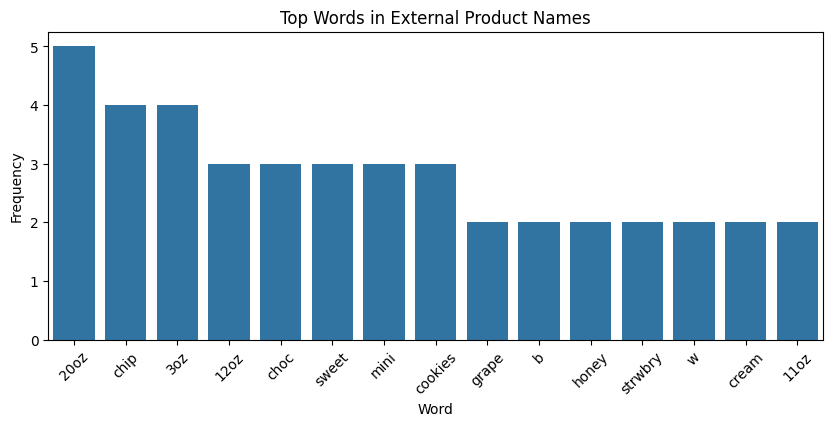

In [24]:
plt.figure(figsize=(10, 4))
sns.barplot(data=top_external_words, x='Word', y='Frequency')
plt.title("Top Words in External Product Names")
plt.xticks(rotation=45)
plt.show()

- Words like "chocolate," "cheese," "milk," "cookie," and "energy" dominate the internal product catalog.

- Size units like "8oz" and "16oz" are frequent, which validates the importance of standardizing sizes for exact matching.

- Ingredient and flavor terms such as "honey", "dark", "peach", "bbq" also appear frequently — showing common product categories or flavor types.

Internal product names are significantly longer and more detailed, usually 30–60 characters.

External names are much shorter, leading to mismatches in exact string comparison.

This difference highlights the need for fuzzy matching and GPT validation to handle variations and improve accuracy.

In [25]:
df_string_internal.duplicated().sum()

np.int64(0)

In [26]:
print("Unique External Products:", df_string_external['cleaned_name'].nunique())
print("Unique Internal Products:", df_string_internal['cleaned_long_name'].nunique())

Unique External Products: 43
Unique Internal Products: 16189


2. For Component-Based (Manufaturer, product name, size) Approach:

In [27]:
df_component_external = external_df.copy()
df_component_internal = internal_df.copy()

In [28]:
def extract_components(name):
    if pd.isna(name):
        return pd.Series(["", "", None])

    original = str(name).lower()

    # Remove extra spaces & punctuation
    cleaned = re.sub(r'[^a-z0-9.\s]', '', original)
    cleaned = re.sub(r'\s+', ' ', cleaned).strip()

    # Extract size and convert to oz if needed
    size_match = re.search(r'(\d+(?:\.\d+)?)\s?(oz|lb|gal)', cleaned)
    size_val = None
    if size_match:
        size_num = float(size_match.group(1))
        unit = size_match.group(2)
        if unit == 'oz':
            size_val = round(size_num, 2)
        elif unit == 'lb':
            size_val = round(size_num * 16, 2)
        elif unit == 'gal':
            size_val = round(size_num * 128, 2)
        # Remove size from product string
        cleaned = re.sub(r'(\d+(?:\.\d+)?)\s?(oz|lb|gal)', '', cleaned)

    # Optional manufacturer logic (simple assumption: first word)
    tokens = cleaned.split()
    manufacturer = tokens[0] if tokens else ""
    product_name = ' '.join(tokens)

    return pd.Series([manufacturer, product_name.strip(), size_val])


In [29]:
# External
df_component_external[['manufacturer_ext', 'product_name_ext', 'size_ext']] = df_component_external['PRODUCT_NAME'].apply(extract_components)

# Internal
df_component_internal[['manufacturer_int', 'product_name_int', 'size_int']] = df_component_internal['LONG_NAME'].apply(extract_components)


In [30]:
df_component_external.tail()

,PRODUCT_NAME,UNIT_OF_MEASURE,manufacturer_ext,product_name_ext,size_ext
38,STARBUCKS DOUBLESHOT + ENG-VAN 15 OZ,1,starbucks,starbucks doubleshot engvan,15.0
39,STONIES PEPR/CHS/JAL .98 OZ,1,stonies,stonies peprchsjal .,98.0
40,Sweet Serenity Choc Chip 3 oz,1,sweet,sweet serenity choc chip,3.0
41,SWEET SERENITY CHOC CHIP COOKIES 3 OZ,1,sweet,sweet serenity choc chip cookies,3.0
42,YOO HOO CHOC. 11 OZ CANS,1,yoo,yoo hoo choc. cans,11.0


In [31]:
df_component_internal.head()

,NAME,OCS_NAME,LONG_NAME,manufacturer_int,product_name_int,size_int
0,3 Mskt DkChocMnt 1.24oz,3 Mskt DkChocMnt 1.24oz,3 Musketeers Dark Chocolate Mint (1.24oz),3,3 musketeers dark chocolate mint,1.24
1,NaN,Costco Choc Mini 4.69lb,Costco Chocolate Mini (4.69lb),costco,costco chocolate mini,75.04
2,Dove Dk Choc Bars 1.3oz,Dove Dk Choc Bars 1.3oz,Dove Dark Chocolate Bars (1.3oz),dove,dove dark chocolate bars,1.30
3,Fishers ChocPnut 3.5oz,Fishers ChocPnut 3.5oz,Fisher's Chocolate Peanuts (3.5oz),fishers,fishers chocolate peanuts,3.50
4,HariboGummiGoldBear2oz,HariboGummiGoldBear2oz,Haribo Gummi Gold-Bears (2oz),haribo,haribo gummi goldbears,2.00


In [32]:
# checking duplicates after standardization the string
print("External Duplicate Record:",df_component_external.duplicated().sum())
print("Internal Duplicate Record:",df_component_internal.duplicated().sum())

External Duplicate Record: 0
Internal Duplicate Record: 2


In [33]:
df_component_internal.drop_duplicates(inplace=True)

In [34]:
df_component_internal.duplicated().sum()


np.int64(0)

EDA FOR THE COMPONENT_BASED APPROACH 

In [35]:
# df_component_internal.columns

In [36]:
df_component_external.columns

Index(['PRODUCT_NAME', 'UNIT_OF_MEASURE', 'manufacturer_ext',
       'product_name_ext', 'size_ext'],
      dtype='object')

In [37]:
# Top manufacturers in external and internal datasets
top_external_mfg = df_component_external['manufacturer_ext'].value_counts().nlargest(10)
top_internal_mfg = df_component_internal['manufacturer_int'].value_counts().nlargest(10)

C:\Users\msura\AppData\Local\Temp\ipykernel_15348\2955248508.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_external_mfg.values, y=top_external_mfg.index, ax=axes[0], palette="Blues_d")
C:\Users\msura\AppData\Local\Temp\ipykernel_15348\2955248508.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_internal_mfg.values, y=top_internal_mfg.index, ax=axes[1], palette="Greens_d")


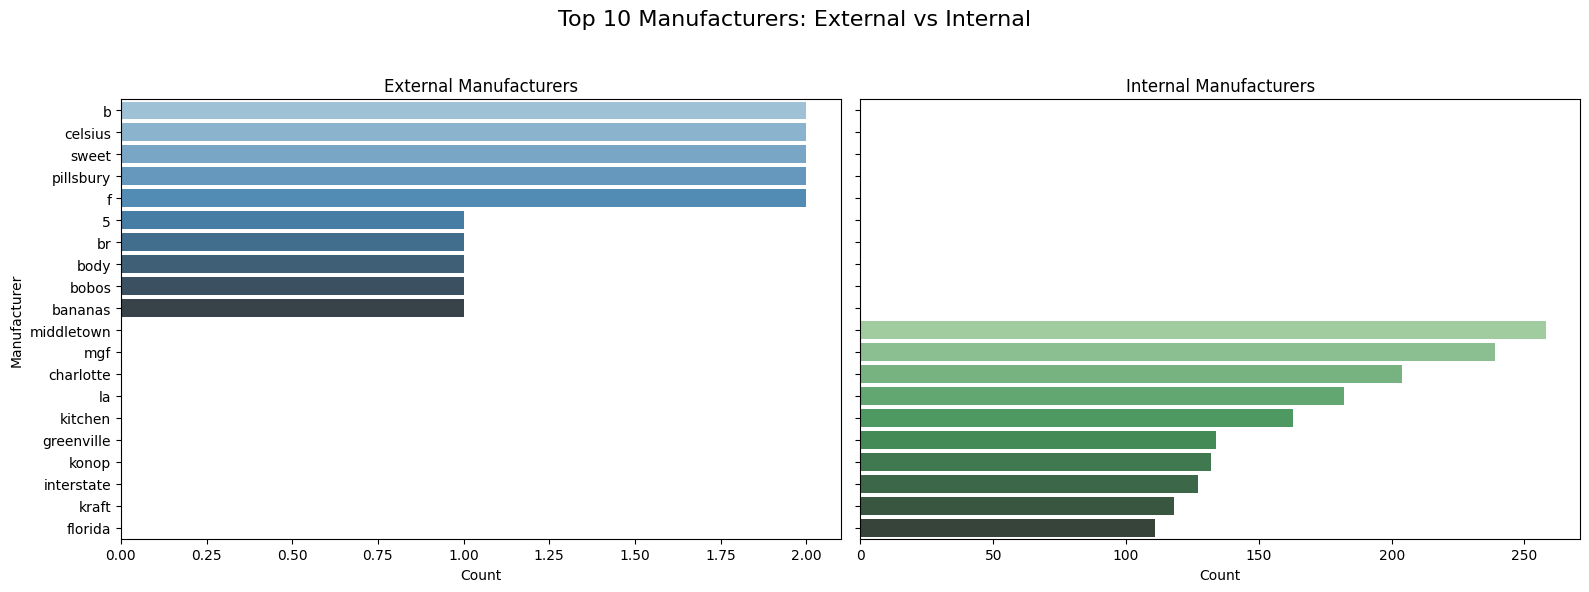

In [38]:
# Plot side-by-side bar charts
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
fig.suptitle("Top 10 Manufacturers: External vs Internal", fontsize=16)

sns.barplot(x=top_external_mfg.values, y=top_external_mfg.index, ax=axes[0], palette="Blues_d")
axes[0].set_title("External Manufacturers")
axes[0].set_xlabel("Count")
axes[0].set_ylabel("Manufacturer")

sns.barplot(x=top_internal_mfg.values, y=top_internal_mfg.index, ax=axes[1], palette="Greens_d")
axes[1].set_title("Internal Manufacturers")
axes[1].set_xlabel("Count")
axes[1].set_ylabel("")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


##### Manufacturer Fragmentation in External Data:

- External manufacturers like b, f, 5, br are likely truncated, inconsistent, or noise—indicating messy data.

- This reduces the chance of direct matches with structured internal names.

##### Internal Dataset Is More Structured:

- Top manufacturers in internal data appear well-formatted and repeated frequently (e.g., consistent casing, full names like kraft, interstate).

- This consistency is ideal for matching, especially if external manufacturer names are cleaned or mapped.

##### Low Overlap Between Sets:

- There's little to no overlap between top names in both datasets.

- Suggests either external suppliers are not yet in the internal system, or names differ significantly (e.g., celcius vs celsius, pillsbury vs pills berry).

##### Implication:
Before exact matching, manufacturer name normalization or fuzzy/entity matching may be needed to bridge the gap between external and internal data.

In [39]:
# Ensure the size columns exist and are numeric
df_component_external['size_oz'] = pd.to_numeric(df_component_external['size_ext'], errors='coerce')
df_component_internal['size_oz'] = pd.to_numeric(df_component_internal['size_int'], errors='coerce')

In [40]:
df_component_external.columns

Index(['PRODUCT_NAME', 'UNIT_OF_MEASURE', 'manufacturer_ext',
       'product_name_ext', 'size_ext', 'size_oz'],
      dtype='object')

C:\Users\msura\AppData\Local\Temp\ipykernel_15348\361595888.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=product_counts_internal.values, y=product_counts_internal.index, palette="crest")


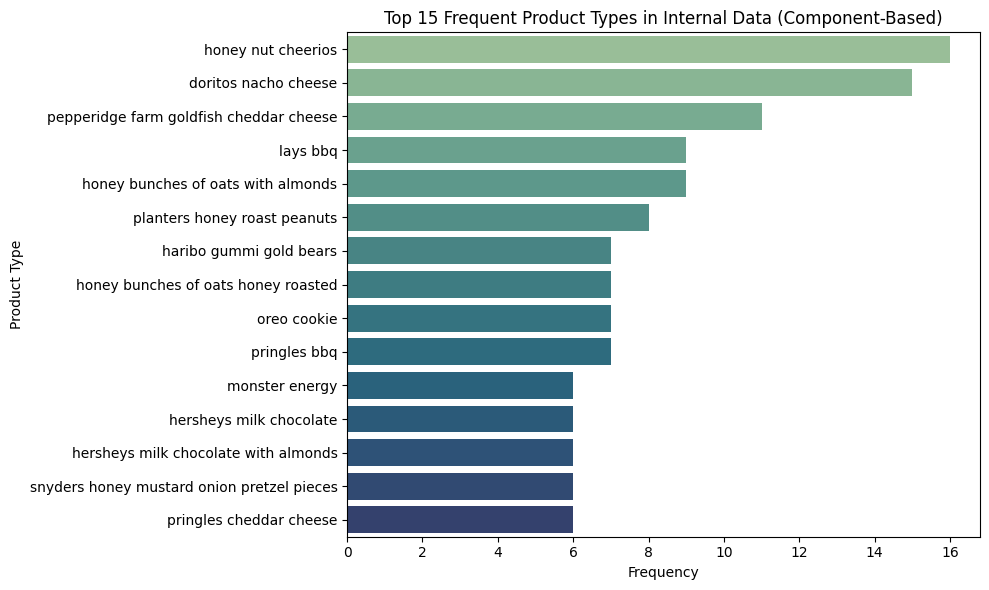

In [41]:
# Get top 15 most frequent product names from internal data using 'product' column
product_counts_internal = df_component_internal['product_name_int'].value_counts().head(15)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x=product_counts_internal.values, y=product_counts_internal.index, palette="crest")
plt.title("Top 15 Frequent Product Types in Internal Data (Component-Based)")
plt.xlabel("Frequency")
plt.ylabel("Product Type")
plt.tight_layout()
plt.show()

External Dataset:

- Repetition / Frequency: Very low – all top 10 product types occur only once.

- Top Product Types: Highly specific (e.g., "bobos pbj grape", "celsius peach vibe").

- Diversity: Extremely high – almost every entry is unique.

- Use Case Nature: Represents supplier shipments, often new or dynamic products.

- Implication on Matching: Exact string matching is difficult; fuzzy matching or GPT assistance is recommended.


Internal Dataset:

- Repetition / Frequency: High – top product type appears more than 16 times.

- Top Product Types: More standardized and branded (e.g., "honey nut cheerios", "doritos nacho cheese").

- Diversity: Moderate – fewer types repeated across many rows.

- Use Case Nature: Reflects in-store inventory, focused on recurring and popular products.

- Implication on Matching: Easier to match due to consistent formatting and known products.


PHASE 4: MATCHING LOGIC IMPLEMENTATION


1. Exact Matching (String-Based Approach)

In [42]:
df_string_external

,PRODUCT_NAME,UNIT_OF_MEASURE,cleaned_name
0,5 HOUR XTRA GRAPE 1.93 OZ,1,5 hour xtra grape 1.93oz
1,B - PB & HONEY SAMMICH,1,b pb honey sammich
2,B - RUDY FARMS - SAUSAGE AND BISCUIT TWIN,1,b rudy farms sausage and biscuit twin
3,BANANAS - FRESH,1,bananas fresh
4,BOBOS PB&J GRAPE 2.1 OZ,1,bobos pbj grape 2.1oz
5,BODY ARMOR STRWBRY BANANA 16 OZ,1,body armor strwbry banana 16oz
6,BR ESPRESSO W/ CREAM 11 OZ,1,br espresso w cream 11oz
7,Bumble Bee Tuna Salad 3.5oz,1,bumble bee tuna salad 3.5oz
8,CELSIUS ORANGE ENERGY 12 OZ,1,celsius orange energy 12oz
9,CELSIUS PEACH VIBE 12 OZ,1,celsius peach vibe 12oz




##### PHASE-4: MATCHING LOGIC
- **Full Matching**: Implementing a direct merge for exact matches between datasets to check if any product are exactly matching.
- **Fuzzy Matching**: Using fuzzy logic as a fallback mechanism for approximate matching.
- **Intelligent Matching**: Integrating prompts with an OpenAI model to enhance and refine the matching process.


1. Perform Full String Match

In [43]:
# Perform full exact match (cleaned external to cleaned internal)
exact_match_df_string = df_string_external.merge(
    df_string_internal,
    how='left',
    left_on='cleaned_name',
    right_on='cleaned_long_name',
    suffixes=('_external', '_internal')
)

In [44]:
# Assign match status
exact_match_df_string['match_status'] = exact_match_df_string['cleaned_long_name'].apply(
    lambda x: 'MATCHED' if pd.notna(x) else 'NULL'
)

In [45]:
# Final result table
final_string_match = exact_match_df_string[[
    'PRODUCT_NAME', 'cleaned_name', 'LONG_NAME', 'cleaned_long_name', 'match_status'
]]

In [46]:
final_string_match

,PRODUCT_NAME,cleaned_name,LONG_NAME,cleaned_long_name,match_status
0,5 HOUR XTRA GRAPE 1.93 OZ,5 hour xtra grape 1.93oz,NaN,NaN,NULL
1,B - PB & HONEY SAMMICH,b pb honey sammich,NaN,NaN,NULL
2,B - RUDY FARMS - SAUSAGE AND BISCUIT TWIN,b rudy farms sausage and biscuit twin,NaN,NaN,NULL
3,BANANAS - FRESH,bananas fresh,NaN,NaN,NULL
4,BOBOS PB&J GRAPE 2.1 OZ,bobos pbj grape 2.1oz,NaN,NaN,NULL
5,BODY ARMOR STRWBRY BANANA 16 OZ,body armor strwbry banana 16oz,NaN,NaN,NULL
6,BR ESPRESSO W/ CREAM 11 OZ,br espresso w cream 11oz,NaN,NaN,NULL
7,Bumble Bee Tuna Salad 3.5oz,bumble bee tuna salad 3.5oz,NaN,NaN,NULL
8,CELSIUS ORANGE ENERGY 12 OZ,celsius orange energy 12oz,NaN,NaN,NULL
9,CELSIUS PEACH VIBE 12 OZ,celsius peach vibe 12oz,NaN,NaN,NULL


##### From the output, it is clear that there are no matches due to differences in naming conventions and abbreviations.

In [47]:
final_output_string_match = final_string_match[[
    'PRODUCT_NAME',           # External raw
    'cleaned_name',           # External cleaned
    'LONG_NAME',              # Internal raw
    'cleaned_long_name',      # Internal cleaned
    'match_status'
]].rename(columns={
    'PRODUCT_NAME': 'External_Product_Name',
    'LONG_NAME': 'Internal_Product_Name'
})

In [48]:
matched_only_df = final_output_string_match[final_output_string_match['match_status'] == 'MATCHED']

In [49]:
matched_only_df

,External_Product_Name,cleaned_name,Internal_Product_Name,cleaned_long_name,match_status


VALIDATING BY APPENDING A FEW RANDOM RECORDS FROM EXTERNAL TO INTERNAL DATASET

In [50]:
test_external_subset = df_string_external[['PRODUCT_NAME', 'cleaned_name']].sample(5, random_state=42).copy()

In [51]:
# Step 2: Create dummy internal rows using the external product names (simulate exact matches)
test_internal_rows = pd.DataFrame({
    'LONG_NAME': test_external_subset['PRODUCT_NAME'],
    'NAME': [None] * len(test_external_subset),
    'OCS_NAME': [None] * len(test_external_subset),
    'cleaned_long_name': test_external_subset['cleaned_name']
})

In [52]:
# Step 3: Append to internal test DataFrame
df_string_internal_test = pd.concat([df_string_internal.copy(), test_internal_rows], ignore_index=True)

In [53]:
df_string_internal_test

,NAME,OCS_NAME,LONG_NAME,cleaned_long_name
0,3 Mskt DkChocMnt 1.24oz,3 Mskt DkChocMnt 1.24oz,3 Musketeers Dark Chocolate Mint (1.24oz),3 musketeers dark chocolate mint 1.24oz
1,NaN,Costco Choc Mini 4.69lb,Costco Chocolate Mini (4.69lb),costco chocolate mini 75.04oz
2,Dove Dk Choc Bars 1.3oz,Dove Dk Choc Bars 1.3oz,Dove Dark Chocolate Bars (1.3oz),dove dark chocolate bars 1.3oz
3,Fishers ChocPnut 3.5oz,Fishers ChocPnut 3.5oz,Fisher's Chocolate Peanuts (3.5oz),fishers chocolate peanuts 3.5oz
4,HariboGummiGoldBear2oz,HariboGummiGoldBear2oz,Haribo Gummi Gold-Bears (2oz),haribo gummi goldbears 2oz
...,...,...,...,...
16190,None,None,SKITTLES ORIG GUMMIES 5.8 OZ,skittles orig gummies 5.8oz
16191,None,None,LSS-CRUNCHY CHEETO,lsscrunchy cheeto
16192,None,None,LSS-DORITOS COOL RANCH,lssdoritos cool ranch
16193,None,None,POP CHIP BBQ .8 OZ,pop chip bbq .8oz


In [54]:
# Step 4: Apply exact matching
test_matched_df = df_string_external.merge(
    df_string_internal_test,
    how='left',
    left_on='cleaned_name',
    right_on='cleaned_long_name',
    suffixes=('_external', '_internal')
)

# Step 5: Create match status
test_matched_df['match_status'] = test_matched_df['cleaned_long_name'].apply(
    lambda x: 'MATCHED' if pd.notna(x) else 'NULL'
)

In [55]:
# Step 6: Final Output Table
final_test_result = test_matched_df[[
    'PRODUCT_NAME', 'cleaned_name', 'LONG_NAME', 'cleaned_long_name', 'match_status'
]]
final_test_result

,PRODUCT_NAME,cleaned_name,LONG_NAME,cleaned_long_name,match_status
0,5 HOUR XTRA GRAPE 1.93 OZ,5 hour xtra grape 1.93oz,NaN,NaN,NULL
1,B - PB & HONEY SAMMICH,b pb honey sammich,NaN,NaN,NULL
2,B - RUDY FARMS - SAUSAGE AND BISCUIT TWIN,b rudy farms sausage and biscuit twin,NaN,NaN,NULL
3,BANANAS - FRESH,bananas fresh,NaN,NaN,NULL
4,BOBOS PB&J GRAPE 2.1 OZ,bobos pbj grape 2.1oz,NaN,NaN,NULL
5,BODY ARMOR STRWBRY BANANA 16 OZ,body armor strwbry banana 16oz,NaN,NaN,NULL
6,BR ESPRESSO W/ CREAM 11 OZ,br espresso w cream 11oz,NaN,NaN,NULL
7,Bumble Bee Tuna Salad 3.5oz,bumble bee tuna salad 3.5oz,NaN,NaN,NULL
8,CELSIUS ORANGE ENERGY 12 OZ,celsius orange energy 12oz,NaN,NaN,NULL
9,CELSIUS PEACH VIBE 12 OZ,celsius peach vibe 12oz,NaN,NaN,NULL


In [56]:
# Filter matched rows only
matched_only_df = test_matched_df[test_matched_df['LONG_NAME'].notnull()]

# Create final output with only matched records
final_output = pd.DataFrame({
    'External_Product_Name': matched_only_df['PRODUCT_NAME'],
    'Internal_Product_Name': matched_only_df['LONG_NAME'],
    'Match_Status': 'MATCHED'
})

final_output.reset_index(drop=True, inplace=True)
final_output

,External_Product_Name,Internal_Product_Name,Match_Status
0,LSS-CRUNCHY CHEETO,LSS-CRUNCHY CHEETO,MATCHED
1,LSS-DORITOS COOL RANCH,LSS-DORITOS COOL RANCH,MATCHED
2,Pillsbury Mini SOFT BAKED Chocolate Chip Cooki...,Pillsbury Mini SOFT BAKED Chocolate Chip Cooki...,MATCHED
3,POP CHIP BBQ .8 OZ,POP CHIP BBQ .8 OZ,MATCHED
4,SKITTLES ORIG GUMMIES 5.8 OZ,SKITTLES ORIG GUMMIES 5.8 OZ,MATCHED


##### 2. FUZZY MATCHING

In [57]:
df_fuzzy_internal = df_string_internal[['LONG_NAME','cleaned_long_name']]
df_fuzzy_external = df_string_external[['PRODUCT_NAME','cleaned_name']]

In [58]:
df_fuzzy_external.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   PRODUCT_NAME  43 non-null     object
 1   cleaned_name  43 non-null     object
dtypes: object(2)
memory usage: 820.0+ bytes


In [59]:
df_fuzzy_internal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16190 entries, 0 to 16191
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   LONG_NAME          16190 non-null  object
 1   cleaned_long_name  16190 non-null  object
dtypes: object(2)
memory usage: 379.5+ KB


In [60]:
# Create a list of unique internal product names
internal_names = df_fuzzy_internal['cleaned_long_name'].dropna().unique().tolist()


def fuzzy_match_product(external_name, internal_list, threshold=90):
    # Try to find the best match for the external_name in the internal_list
    result = process.extractOne(
        external_name,
        internal_list,
        scorer=fuzz.token_sort_ratio,
        score_cutoff=threshold
    )
    if result:
        # result is a tuple (matched_string, score, index)
        return result[0], result[1]  # (best match string, similarity score)
    return None, None

# Apply the fuzzy_match_product function to each cleaned_name in the external DataFrame
df_fuzzy_external['fuzzy_match'],df_fuzzy_external['fuzzy_score'] = zip(*df_fuzzy_external['cleaned_name'].apply(
    lambda x: fuzzy_match_product(x, internal_names, threshold=85)
))

# Inspect the results
df_fuzzy_external[['PRODUCT_NAME', 'cleaned_name', 'fuzzy_match', 'fuzzy_score']]


,PRODUCT_NAME,cleaned_name,fuzzy_match,fuzzy_score
0,5 HOUR XTRA GRAPE 1.93 OZ,5 hour xtra grape 1.93oz,None,NaN
1,B - PB & HONEY SAMMICH,b pb honey sammich,None,NaN
2,B - RUDY FARMS - SAUSAGE AND BISCUIT TWIN,b rudy farms sausage and biscuit twin,None,NaN
3,BANANAS - FRESH,bananas fresh,None,NaN
4,BOBOS PB&J GRAPE 2.1 OZ,bobos pbj grape 2.1oz,None,NaN
5,BODY ARMOR STRWBRY BANANA 16 OZ,body armor strwbry banana 16oz,None,NaN
6,BR ESPRESSO W/ CREAM 11 OZ,br espresso w cream 11oz,None,NaN
7,Bumble Bee Tuna Salad 3.5oz,bumble bee tuna salad 3.5oz,bumble bee tuna salad kit 4oz,85.714286
8,CELSIUS ORANGE ENERGY 12 OZ,celsius orange energy 12oz,None,NaN
9,CELSIUS PEACH VIBE 12 OZ,celsius peach vibe 12oz,None,NaN


1. DOVE BAR DARK CHOC 1.44 OZ	dove bar dark choc 1.44oz	dove dark chocolate bar 1.44oz	90.909091

2. Pillsbury Soft Baked Confetti Cookies 3oz	pillsbury soft baked confetti cookies 3oz	pillsbury mini soft baked confetti cookies 3oz	94.252874

#### 3. PROMPT ENGINEERING WITH OPEN AI MODEL "GPT-4"

In [61]:
from openai import OpenAI

In [ ]:
# Initialize OpenAI client
client = OpenAI(api_key="please generate API key and paste here") 

#### Please note: I will be submitting this API key for validation purposes. However, since it is tied to a limited testing budget, it may stop functioning once the token usage exceeds the allowed limit.

In [63]:
def build_prompt(external_name, internal_name):
    return f"""
SYSTEM (Context & Role):
You are an AI assistant specializing in product matching between an external supplier's product and an internal product catalog. You have deep expertise in product naming conventions and sizing formats.

USER (Instructions & Format):
You will be given two product names:
1. External product (from the supplier)
2. Internal product (from our catalog)

According to our business rules, these products should be considered a valid match only if ALL the following criteria are met:
1. The manufacturer (brand) is exactly the same.
2. The product names are semantically equivalent.
3. The sizes are exactly the same, including both the numerical value and the unit. Valid units include oz, lb, and gallon. For example, "20 oz" is equivalent to "20oz", but "20 oz" does not match "20.5 oz", nor does a product measured in oz match one measured in lb or gallon.

Your task:
- Compare the external product name with the internal product name.
- Decide if all three criteria are met.
- Respond with exactly one word: either "MATCH" or "NO MATCH" (all caps).
- Do not provide any additional text or explanation.

EXAMPLES:

Example A Correct Match:
External: "DIET LIPTON GREEN TEA W/ CITRUS 20 OZ"
Internal: "Lipton Diet Green Tea with Citrus (20oz)"
Analysis:
  • Brand: "Lipton" vs. "Lipton" (match)
  • Product Name: "Diet Green Tea with Citrus" vs. "Diet Green Tea with Citrus" (semantically equivalent)
  • Size: "20 OZ" vs. "20oz" (match, same numerical value and unit)
Correct response: MATCH

Example B Wrong Match:
External: "Hersheys Almond Milk Choco 1.6 oz"
Internal: "Hersheys Milk Chocolate with Almonds (1.85oz)"
Analysis:
  • Brand: "Hersheys" vs. "Hersheys" (brand matches)
  • Product Name: "Almond Milk Choco" vs. "Milk Chocolate with Almonds" (not semantically equivalent)
  • Size: "1.6 oz" vs. "1.85oz" (different numerical value)
Correct response: NO MATCH

Example C Wrong Match (Different Units):
External: "Some Product 2 lb"
Internal: "Some Product (2 gallon)"
Analysis:
  • Brand: (if brands match)
  • Product Name: (if semantically equivalent)
  • Size: "2 lb" vs. "2 gallon" (different units)
Correct response: NO MATCH

Example D Correct Match :
External: "CH-CHERRY CHS CLAW DANISH 4.25 OZ"
Internal: "Cloverhill Cherry Cheese Bearclaw Danish (4.25oz)"
Analysis:
  • Brand: (assumed matching based on context)
  • Product Name: "CH-CHERRY CHS CLAW DANISH" vs. "Cherry Cheese Bearclaw Danish" (semantically equivalent)
  • Size: "4.25 OZ" vs. "4.25oz" (match)
Correct response: MATCH

Example E Wrong Match (Different Product Name):
External: "COOKIE PEANUT BUTTER 2OZ"
Internal: "Famous Amos Peanut Butter Cookie (2oz)"
Analysis:
  • Brand: "COOKIE" vs. "Famous Amos" (different brands)
  • Product Name: "PEANUT BUTTER" vs. "Peanut Butter Cookie" (different product types)
  • Size: "2OZ" vs. "2oz" (size matches, but other criteria fail)
Correct response: NO MATCH

Now compare:

External product: "{external_name}"
Internal product: "{internal_name}"

Please respond with exactly "MATCH" or "NO MATCH" (all caps).

"""


In [64]:
def validate_with_gpt(external_name, internal_name):
    if pd.isna(internal_name) or not external_name:
        return "NO MATCH"
    
    prompt = build_prompt(external_name, internal_name)

    try:
        response = client.chat.completions.create(
            model="gpt-4",
            messages=[
                {"role": "system", "content": "You are a strict product matcher."},
                {"role": "user", "content": prompt}
            ],
            max_tokens=5,
            temperature=0.0 # have set the temperature to 0.0 since the business requirement is find the exact matches
        )
        answer = response.choices[0].message.content.strip().upper()
        return "MATCH" if answer == "MATCH" else "NO MATCH"


    except Exception as e:
        return f"ERROR: {str(e)}"

#### VALIDATING THE LLM MODEL WITH GIVEN PROMPT

In [65]:
external_name = "DIET LIPTON GREEN TEA W/ CITRUS 20 OZ"
internal_name = "Lipton Diet Green Tea with Citrus (20oz)"

In [66]:
decision = validate_with_gpt(external_name, internal_name)
print("GPT Decision:", decision)

GPT Decision: MATCH


#### VALIDATING THE PRODUCT MATCHES FROM THE ACTUAL EXTERNAL AND INTERNAL DATA

In [67]:
external_name = "Bumble Bee Tuna Salad 3.5oz"
internal_name = "Bumble Bee Tuna Salad with Crackers (3.5oz)"

In [68]:
decision = validate_with_gpt(external_name, internal_name)
print("GPT Decision:", decision)

GPT Decision: NO MATCH


In [69]:
external_name = "DOVE BAR DARK CHOC 1.44 OZ"
internal_name = "Dove Peanut Butter Milk Chocolate Bar (1.16oz)"

In [70]:
decision = validate_with_gpt(external_name, internal_name)
print("GPT Decision:", decision)

GPT Decision: NO MATCH


In [71]:
external_name = "Pillsbury Soft Baked Confetti Cookies 3oz"
internal_name = "Pillsbury Mini Chocolate Chip Muffin (3oz)"

In [72]:
decision = validate_with_gpt(external_name, internal_name)
print("GPT Decision:", decision)

GPT Decision: NO MATCH


In [73]:
external_name = "Sweet Serenity Choc Chip 3 oz"
internal_name="Rhino Rush Grape Energy (1.8oz)"

In [74]:
decision = validate_with_gpt(external_name, internal_name)
print("GPT Decision:", decision)

GPT Decision: NO MATCH


In [75]:
external_name="Sweet Serenity Choc Chip 3 oz"
internal_name = "Sweet Serenity Chocolate Chip Bite Size Cookies (2oz)"

In [76]:
decision = validate_with_gpt(external_name, internal_name)
print("GPT Decision:", decision)

GPT Decision: NO MATCH


#### FUZZY AND GPT IMPLEMENTATION TOGETHER

- Fuzzy matching helps find close matches even if product names aren't identical.

- But fuzzy alone isn't enough — it can miss important business rules like brand or size.

- GPT acts as a smart validator after fuzzy — it checks if brand, name, and size match.

- We first apply fuzzy logic, then run GPT on top suggestions to confirm if it’s a real match.

- This combo gives us the best of both worlds: speed from fuzzy, accuracy from GPT.

- The final result includes fuzzy score + GPT’s decision: “MATCH” or “NO MATCH”.

In [77]:
def fuzzy_match_product(external_name, internal_names, threshold=80):
    result = process.extractOne(
        external_name,
        internal_names,
        scorer=fuzz.token_sort_ratio,
        score_cutoff=threshold
    )
    if result:
        return result[0], result[1]
    return None, None


subset = df_string_external.copy()

internal_names = df_string_internal['cleaned_long_name'].dropna().unique().tolist()

# Fuzzy match
df_string_external['Internal_Product_Name'], df_string_external['Fuzzy_Score'] = zip(*df_string_external['cleaned_name'].apply(
    lambda x: fuzzy_match_product(x, internal_names)
))

# Fill NULL where no match found
df_string_external['Internal_Product_Name'] = df_string_external['Internal_Product_Name'].fillna('NULL')

# GPT Decision
df_string_external['GPT_Decision'] = df_string_external.apply(
    lambda row: validate_with_gpt(row['PRODUCT_NAME'], row['Internal_Product_Name']) 
    if row['Internal_Product_Name'] != 'NULL' else 'NO MATCH',
    axis=1
)

# Final Display Columns
final_output = df_string_external[['PRODUCT_NAME', 'Internal_Product_Name', 'Fuzzy_Score', 'GPT_Decision']].rename(columns={
    'PRODUCT_NAME': 'External_Product_Name'
})

In [78]:
final_output

,External_Product_Name,Internal_Product_Name,Fuzzy_Score,GPT_Decision
0,5 HOUR XTRA GRAPE 1.93 OZ,NULL,NaN,NO MATCH
1,B - PB & HONEY SAMMICH,NULL,NaN,NO MATCH
2,B - RUDY FARMS - SAUSAGE AND BISCUIT TWIN,NULL,NaN,NO MATCH
3,BANANAS - FRESH,NULL,NaN,NO MATCH
4,BOBOS PB&J GRAPE 2.1 OZ,NULL,NaN,NO MATCH
5,BODY ARMOR STRWBRY BANANA 16 OZ,NULL,NaN,NO MATCH
6,BR ESPRESSO W/ CREAM 11 OZ,NULL,NaN,NO MATCH
7,Bumble Bee Tuna Salad 3.5oz,bumble bee tuna salad kit 4oz,85.714286,NO MATCH
8,CELSIUS ORANGE ENERGY 12 OZ,NULL,NaN,NO MATCH
9,CELSIUS PEACH VIBE 12 OZ,celsius sparkling peach vibe 12oz,82.142857,MATCH


##### Insights from Final Product Matching Output (Fuzzy + GPT)

- Used fuzzy logic to find top internal matches for external products.

- Applied GPT to validate those matches strictly (brand, name, size).

- 7 out of 43 products were confirmed as exact matches.

- GPT prevented false matches, even when fuzzy scores were high.

- Ensures only high-confidence matches are retained.

In [79]:
## Final output format for deliverable 1
# GPT Decision
df_string_external['GPT_Decision'] = df_string_external.apply(
    lambda row: validate_with_gpt(row['PRODUCT_NAME'], row['Internal_Product_Name']) 
    if row['Internal_Product_Name'] != 'NULL' else 'NO MATCH',
    axis=1
)

# Add Match Status column based on GPT Decision
df_string_external['Match_Status'] = df_string_external['GPT_Decision'].apply(
    lambda x: 'MATCHED' if x == 'MATCH' else 'NO MATCH'
)

# Final Output: without fuzzy score and GPT decision
final_output = df_string_external[['PRODUCT_NAME', 'Internal_Product_Name', 'Match_Status']].rename(columns={
    'PRODUCT_NAME': 'External_Product_Name'
})



In [80]:
final_output

,External_Product_Name,Internal_Product_Name,Match_Status
0,5 HOUR XTRA GRAPE 1.93 OZ,NULL,NO MATCH
1,B - PB & HONEY SAMMICH,NULL,NO MATCH
2,B - RUDY FARMS - SAUSAGE AND BISCUIT TWIN,NULL,NO MATCH
3,BANANAS - FRESH,NULL,NO MATCH
4,BOBOS PB&J GRAPE 2.1 OZ,NULL,NO MATCH
5,BODY ARMOR STRWBRY BANANA 16 OZ,NULL,NO MATCH
6,BR ESPRESSO W/ CREAM 11 OZ,NULL,NO MATCH
7,Bumble Bee Tuna Salad 3.5oz,bumble bee tuna salad kit 4oz,NO MATCH
8,CELSIUS ORANGE ENERGY 12 OZ,NULL,NO MATCH
9,CELSIUS PEACH VIBE 12 OZ,celsius sparkling peach vibe 12oz,MATCHED
